In [21]:
import numpy as np
import pandas as pd
import gensim
import time
import statistics as st

from gensim import corpora
from pprint import pprint
from gensim.models import Word2Vec
from collections import Counter

import numpy as np 
import nltk 
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer    
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer 

from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

full_dataset = pd.read_csv("/content/drive/My Drive/Colab_Data/0306/30k1k/training_with_avg_cred.csv")
print(full_dataset.info)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<bound method DataFrame.info of                                                      text  ...  avg_cred
0       RT @Deadline: ‘Avengers: Age Of Ultron’ Traile...  ...  0.600000
1       RT @billpostmus: [MORE] Obama's Ebola Czar Ron...  ...  0.666667
2       RT @MarcHilliker: Obama’s Ebola Czar Has No Me...  ...  0.666667
3       [MORE] Obama's Ebola Czar Ron Klain: Partisan ...  ...  0.666667
4       RT @Meeeech_L: Have you heard of Dr Lurie? No?...  ...  0.666667
...                                                   ...  ...       ...
140659  Praying for a Redskins win because fuck the co...  ...  2.000000
140660  I want the Cowboys to win just 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#########################################################################################################
#The Elbow Method
def calculate_WSS(points, kmax): 
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
    plt.plot(sse)
  return sse

#########################################################################################################
#vectorization of sentence 
def sent_vectorizer(sent):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            sent_vec.append(model[w])
        except:
            pass
     
    return sent_vec


#########################################################################################################
#lemmatization od sentence 
def lemmatization(text):
    return [lemmatizer.lemmatize(w) for w in text]
#########################################################################################################
#stemming word  
def stemmeriation(text):
    return [ps.stem(w) for w in text]
    
#########################################################################################################
#get the mean of the vector of a sentence 
def avg_vect(sent_vec):
    sum_of_vec = 0
    for word in sent_vec:
      sum_of_vec+= np.mean(word)
    if(len(sent_vec)>0):
      return (sum_of_vec/len(sent_vec))  
    return 0
#########################################################################################################
#print each sentence 
def sent_print(sent):
    print(sent)

In [24]:

print(full_dataset.loc[0])

text                         RT @Deadline: ‘Avengers: Age Of Ultron’ Traile...
id                                                                 5.25102e+17
author_id                                                          1.78809e+08
created_at                                                 2014-10-23 01:50:01
in_reply_to_status_id_str                                                  NaN
in_reply_to_user_id_str                                                    NaN
in_reply_to_screen_name                                                    NaN
quoted_status_id_str                                                      None
retweet_id                                                  525094827650588675
retweet_author_id                                                    586032653
topic                                                     ebola,free,sometimes
topic_key                    ebola_free_sometimes-20141020_101221-20141020_...
topic_terms                                  [u'ebol

In [25]:
#text pre-processing
not_words = ['!','@','?',',','.',"'", ')',';','(', '/',':','-','&','*','"','\'','\"','...','..','=]','=[','rt']

tweet_dataset = full_dataset[['id','text','avg_cred']]
tweet_tokenizer = TweetTokenizer()
tweet_tokens = []
for sent in tweet_dataset['text']:
    tweet_tokens.append(tweet_tokenizer.tokenize(str(sent).lower()))
tweet_dataset['tokenized_text'] = tweet_tokens

tweet_dataset['tokenized_text'] = tweet_dataset['tokenized_text'].apply(lambda x: [item for item in x if item not in not_words])

for sentence in tweet_dataset['tokenized_text']: 
    num_to_del = 0
    for word in sentence:
        if '@' in word: 
            num_to_del +=1
    for i in range(0,num_to_del):
        for word in sentence:
            if '@' in word: 
                sentence.remove(word)  
                
for sentence in tweet_dataset['tokenized_text']: 
    num_to_del = 0
    for word in sentence:
        if 'http' in word: 
            num_to_del +=1
    for i in range(0,num_to_del):
        for word in sentence:
            if 'http' in word: 
                sentence.remove(word)  


            
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [26]:
#remove stop words
stop_words = set(stopwords.words('english')) 
tweet_dataset['text_without_stop_word'] = tweet_dataset['tokenized_text'].apply(lambda x: [item for item in x if item not in stop_words])
#stem
ps = PorterStemmer() 
tweet_dataset['stemmed_text'] = tweet_dataset['text_without_stop_word'].apply(stemmeriation)

#lemma
lemmatizer = WordNetLemmatizer() 
tweet_dataset['lemmatized_text'] = tweet_dataset['stemmed_text'].apply(lemmatization)

print(tweet_dataset['lemmatized_text'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0         [‘, aveng, age, ultron, ’, trailer, marvel, re...
1         [[, ], obama', ebola, czar, ron, klain, partis...
2         [obama, ’, ebola, czar, medic, health, care, b...
3         [[, ], obama', ebola, czar, ron, klain, partis...
4         [heard, dr, luri, that', weird, sinc, respons,...
                                ...                        
140659                   [pray, redskin, win, fuck, cowboy]
140660                   [want, cowboy, win, like, redskin]
140661             [also, need, redskin, win, hate, cowboy]
140662    [would, #incred, #redskin, win, #cowboy, they'...
140663                     [2015, host, talk, he', tomm, >]
Name: lemmatized_text, Length: 140664, dtype: object


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [27]:
#build word2vec model and run on each sentences 
import gensim.downloader as api
from gensim.models import KeyedVectors
path = api.load("word2vec-google-news-300", return_path=True)
print(path)
#model = Word2Vec(tweet_dataset['lemmatized_text'], min_count=1,size= 32)
model = KeyedVectors.load_word2vec_format(path, binary=True)
#tweet_dataset['vector_text'] = np.array([model[word] for word in (model.wv.vocab)])
tweet_dataset['vector_text'] = tweet_dataset['lemmatized_text'].apply(sent_vectorizer)

print((tweet_dataset['vector_text'][0]))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
[array([ 1.55273438e-01,  2.08984375e-01, -1.51367188e-01, -3.27148438e-02,
       -1.92871094e-02,  2.38037109e-02,  2.71484375e-01, -6.64062500e-02,
        1.41601562e-01,  1.74560547e-02,  7.47070312e-02, -1.07910156e-01,
       -2.51953125e-01, -2.43164062e-01, -1.35742188e-01, -1.81640625e-01,
        1.14257812e-01,  3.82812500e-01,  4.69970703e-03, -2.32421875e-01,
       -1.20117188e-01, -2.29492188e-01, -1.40625000e-01,  3.88183594e-02,
       -9.76562500e-02, -3.39843750e-01, -2.00195312e-01,  1.40625000e-01,
        1.75781250e-02, -7.17773438e-02, -1.47460938e-01, -1.20117188e-01,
       -2.18505859e-02,  6.34765625e-02, -4.80957031e-02,  7.22656250e-02,
        3.44238281e-02, -1.40625000e-01, -1.23046875e-01,  2.57812500e-01,
        3.34167480e-03,  2.38281250e-01,  1.11816406e-01, -2.13867188e-01,
        1.29882812e-01,  1.14746094e-01, -9.27734375e-02,  1.66015625e-01,
       -2.32421875e-01, -1.4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [28]:
############################################################################################
#get the avg vector of all vectors in a sentence 
def avg_vector(vect_list):
  return np.mean(vect_list, axis=0)

def max_vector(vect_list):
  return np.maximum(vect_list)

def min_vector(vect_list):
  tmp=[]
  for v in vect_list:
    tmp.append(float(v))
  return min(tmp)
#return the len of the sentence 
def get_text_len(text):
  return len(text)


tweet_dataset['avg_vector_text'] = tweet_dataset['vector_text'].apply(avg_vector)
#tweet_dataset['max_vector_text'] = tweet_dataset['vector_text'].apply(max_vector)
#tweet_dataset['min_vector_text'] = tweet_dataset['vector_text'].apply(min_vector)

tweet_dataset['len_text'] = tweet_dataset['vector_text'].apply(get_text_len)

############################################################################################
#replace all nan value of sentence into zero vector
def get_list(vect_list):
  re_list = []
  #print(vect_list)
  if not np.isnan(vect_list).any():   
    return vect_list
  else:
    return ([0] * 32)
############################################################################################
#iterative to call the 
def loop_rolist(vect_list):
  return vect_list.tolist()
############################################################################################


tweet_dataset['avg_vector_text'] = tweet_dataset['avg_vector_text'].apply(get_list)
#tweet_dataset['max_vector_text'] = tweet_dataset['max_vector_text'].apply(get_list)
#tweet_dataset['min_vector_text'] = tweet_dataset['min_vector_text'].apply(get_list)
#tweet_dataset['len_text'] = tweet_dataset['len_text'].apply(get_list)
print(tweet_dataset['avg_vector_text'])
wws_dataset = tweet_dataset.sample(n=10000)
vec_data = pd.DataFrame(tweet_dataset['avg_vector_text'].tolist(),tweet_dataset['avg_cred'].tolist() )
#vec_data = pd.DataFrame(tweet_dataset['avg_vector_text'].tolist())



print(vec_data)

#vec_data: pandas to cluster, contain the 32 col of average vector and one col contain the length of a the sentence 


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

0         [0.071132116, 0.03226144, -0.13410296, -0.0262...
1         [0.051798504, 0.016194662, 0.112345375, 0.1113...
2         [0.04421165, -0.005057595, 0.120666504, 0.0995...
3         [0.051798504, 0.016194662, 0.112345375, 0.1113...
4         [-0.07059152, 0.0018822806, 0.08257185, 0.0856...
                                ...                        
140659    [0.0640625, -0.15161133, 0.11838379, 0.1974609...
140660    [0.074121095, -0.034179688, 0.062026978, 0.131...
140661    [0.053985596, -0.04405721, 0.06981913, 0.09212...
140662    [0.16833496, 0.11633301, 0.08201599, 0.0166015...
140663    [-0.20376205, 0.07797241, 0.047073364, 0.10430...
Name: avg_vector_text, Length: 140664, dtype: object
               0         1         2    ...       297       298       299
0.600000  0.071132  0.032261 -0.134103  ... -0.076050 -0.042010  0.006557
0.666667  0.051799  0.016195  0.112345  ... -0.035506  0.000854  0.038005
0.666667  0.044212 -0.005058  0.120667  ... -0.077428  0.103030  

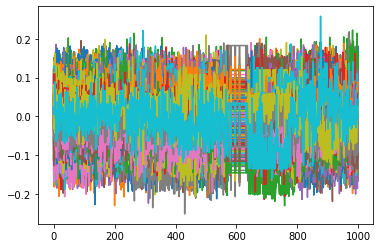

In [29]:
#normalization
from sklearn import preprocessing
vec_data[np.isnan(vec_data)] = 0
x = vec_data 
min_max_scaler = preprocessing.Normalizer()
normalizsed_dataset_array = min_max_scaler.fit_transform(x)
nor_df = pd.DataFrame(normalizsed_dataset_array)
plt.plot(nor_df[0:1000])


[382.10999781235455,
 125.59584215960518,
 111.44474060017149,
 108.97950118177728,
 99.07341424501473,
 92.62013409033493,
 82.01314808003902,
 83.20402166791222,
 74.4475711461948,
 75.36094323683302,
 76.78727796709074,
 74.95620350255237,
 72.52574755003171,
 72.83422714504994,
 68.84678504268011,
 71.05909764086483,
 68.45757401976728,
 68.26766078832647,
 65.42608380632714,
 67.93976776608612]

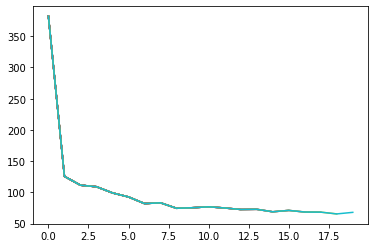

In [ ]:
#Elbow Method
calculate_WSS(normalizsed_dataset_array,20) 

In [ ]:
#k-mean clusteirng 

kmeans = cluster.KMeans(n_clusters=6)
start_time = time.time()
kmeans.fit(normalizsed_dataset_array)
print("--- %s seconds ---" % (time.time() - start_time))
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print ("Cluster id labels for inp utted data")
print (labels)
print ("Centroids data")
print (centroids)

--- 25.257080078125 seconds ---
Cluster id labels for inp utted data
[0 0 0 ... 0 0 0]
Centroids data
[[ 2.30151921e-03  2.87820976e-02  1.02258606e-02 ... -4.39259296e-02
  -1.55712159e-02 -8.27700424e-03]
 [ 3.24253991e-05 -3.34408887e-05  2.97215170e-06 ... -6.50289344e-05
   1.53324901e-05 -1.44094735e-05]
 [-9.02659651e-02  2.31642791e-02  5.02141793e-02 ... -4.12473615e-02
  -1.62149954e-02  3.16827560e-02]
 [ 3.91477540e-02 -1.07013487e-02 -2.49618138e-02 ... -3.32738225e-02
   2.02011358e-02 -3.16505163e-02]
 [ 2.06318227e-02 -9.48924980e-03 -8.28288554e-02 ...  4.46696521e-02
   4.20664017e-02  5.67562983e-03]
 [-3.12686240e-02  2.04290660e-02  3.48012149e-02 ... -4.10484309e-02
  -2.07418678e-02  4.52148182e-02]]


In [30]:
#make gp as a col and output it as a csv file
full_dataset['gp'] = labels 
full_dataset.to_csv('COMP4641_text_clustering_with_cred_result.csv',index=False)

ValueError: ignored

In [31]:
full_dataset

,text,id,author_id,created_at,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,quoted_status_id_str,retweet_id,retweet_author_id,topic,topic_key,topic_terms,Cred_Ratings,Reasons,avg_cred
0,RT @Deadline: ‘Avengers: Age Of Ultron’ Traile...,5.251018e+17,1.788087e+08,2014-10-23 01:50:01,NaN,NaN,NaN,None,525094827650588675,586032653,"ebola,free,sometimes",ebola_free_sometimes-20141020_101221-20141020_...,"[u'ebola', u'free', u'sometimes']","['2', '2', '-1', '1', '0', '-1', '0', '2', '-2...",['There are reputable news agencies online rep...,0.600000
1,RT @billpostmus: [MORE] Obama's Ebola Czar Ron...,5.232322e+17,2.699981e+07,2014-10-17 22:00:50,NaN,NaN,NaN,None,523231974131916800,379962842,"ebola,obama,#ebola",ebola_obama_#ebola-20141016_181953-20141016_19...,"[u'ebola', u'obama', u'#ebola']","['1', '0', '2', '2', '2', '-2', '-2', '2', '2'...",['obama wants to intensify action against ebol...,0.666667
2,RT @MarcHilliker: Obama’s Ebola Czar Has No Me...,5.232320e+17,2.363137e+09,2014-10-17 22:00:01,NaN,NaN,NaN,None,523204296695742464,143695063,"ebola,obama,#ebola",ebola_obama_#ebola-20141016_181953-20141016_19...,"[u'ebola', u'obama', u'#ebola']","['1', '0', '2', '2', '2', '-2', '-2', '2', '2'...",['obama wants to intensify action against ebol...,0.666667
3,[MORE] Obama's Ebola Czar Ron Klain: Partisan ...,5.232320e+17,3.799628e+08,2014-10-17 21:59:58,NaN,NaN,NaN,None,None,None,"ebola,obama,#ebola",ebola_obama_#ebola-20141016_181953-20141016_19...,"[u'ebola', u'obama', u'#ebola']","['1', '0', '2', '2', '2', '-2', '-2', '2', '2'...",['obama wants to intensify action against ebol...,0.666667
4,RT @Meeeech_L: Have you heard of Dr Lurie? No?...,5.232285e+17,2.886221e+07,2014-10-17 21:46:10,NaN,NaN,NaN,None,522072489263136768,341330995,"ebola,obama,#ebola",ebola_obama_#ebola-20141016_181953-20141016_19...,"[u'ebola', u'obama', u'#ebola']","['1', '0', '2', '2', '2', '-2', '-2', '2', '2'...",['obama wants to intensify action against ebol...,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140659,Praying for a Redskins win because fuck the co...,5.269211e+17,1.016176e+09,2014-10-28 02:19:03,NaN,NaN,NaN,None,None,None,"age,trailer,ultron",age_trailer_ultron-20141023_082640-20141023_09...,"[u'age', u'trailer', u'ultron']","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",['Avengers Age of Ultron teaser trailer releas...,2.000000
140660,I want the Cowboys to win just because I don't...,5.269301e+17,3.307641e+08,2014-10-28 02:55:11,NaN,NaN,NaN,None,None,None,"age,trailer,ultron",age_trailer_ultron-20141023_082640-20141023_09...,"[u'age', u'trailer', u'ultron']","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",['Avengers Age of Ultron teaser trailer releas...,2.000000
140661,I also need the redskins to win because I hate...,5.269351e+17,7.563905e+08,2014-10-28 03:14:52,NaN,NaN,NaN,None,None,None,"age,trailer,ultron",age_trailer_ultron-20141023_082640-20141023_09...,"[u'age', u'trailer', u'ultron']","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",['Avengers Age of Ultron teaser trailer releas...,2.000000
140662,It would be #Incredible that #Redskins were to...,5.269361e+17,3.419306e+08,2014-10-28 03:18:39,NaN,NaN,NaN,None,None,None,"age,trailer,ultron",age_trailer_ultron-20141023_082640-20141023_09...,"[u'age', u'trailer', u'ultron']","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",['Avengers Age of Ultron teaser trailer releas...,2.000000


In [ ]:
tweet_dataset['gp'] = labels 
print(tweet_dataset.loc[0])

id                                                       522524498634211328
text                      RT @SportsCenter: The Kansas City Royals are g...
tokenized_text            [the, kansas, city, royals, are, going, to, th...
text_without_stop_word    [kansas, city, royals, going, world, series, f...
stemmed_text              [kansa, citi, royal, go, world, seri, finish, ...
lemmatized_text           [kansa, citi, royal, go, world, seri, finish, ...
vector_text               [[4.1704984, 0.42072827, 2.2964933, 0.22246811...
avg_vector_text           [1.4439049, -0.7935917, 1.1173176, 0.35545883,...
gp                                                                        2
Name: 0, dtype: object


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#Optional to run, try to print out the top n frequnecy words of a gp
from collections import Counter

top_word_list =[]
for i in range(7):
    list1 = []
    list2 = []
    list1=tweet_dataset.lemmatized_text[tweet_dataset['gp']==i]
    list2 = sum(list1, [])
    #print(list2)
    counts = Counter(list2).most_common(40)
    print(counts)
    top_word_list.append(counts)
    


KeyError: ignored

In [ ]:
#DBSCAN
#we have not enough computation power to run, even colab have memory error 
start_time = time.time()
clustering = DBSCAN(eps=0.7).fit(normalizsed_dataset_array)
tweet_dataset['gp'] =clustering.labels_ 
full_dataset['gp'] = clustering.labels_ 
print("--- %s seconds ---" % (time.time() - start_time))
print(full_dataset)
print(tweet_dataset.gp.max())
#Full_tweet_dataset.to_csv('DBSCAN_with_normalized.csv',index=False)

In [ ]:
print(tweet_dataset.gp.max())
#Optional to run, try to print out the top n frequnecy words of a gp
from collections import Counter

top_word_list =[]
for i in range(31):
    list1 = []
    list2 = []
    list1=tweet_dataset.lemmatized_text[tweet_dataset['gp']==i]
    list2 = sum(list1, [])
    #print(list2)
    counts = Counter(list2).most_common(40)
    print(counts)
    top_word_list.append(counts)


31
[('ा', 24), ('े', 15), ('ी', 15), ('ं', 10), ('்', 9), ('म', 8), ('क', 8), ('स', 7), ('्', 7), ('ड', 6), ('न', 6), ('र', 6), ('ு', 6), ('ி', 5), ('க', 5), ('！', 5), ('ज', 4), ('ो', 4), ('ि', 4), ('ल', 4), ('่', 4), ('ब', 3), ('ु', 3), ('ट', 3), ('・', 3), ('。', 3), ('ர', 3), ('ா', 3), ('アベンジャーズ', 3), ('व', 2), ('च', 2), ('भ', 2), ('रत', 2), ('ग', 2), ('य', 2), ('त', 2), ('ए', 2), ('थ', 2), ('、', 2), ('ெ', 2)]
[('…', 1220), ('game', 1205), ('liverpool', 1041), ('madrid', 1022), ('real', 1014), ('trailer', 1012), ('win', 991), ('age', 982), ('ultron', 954), ('aveng', 878), ('record', 827), ('seri', 770), ('world', 704), ('ebola', 628), ('bumgarn', 583), ('giant', 566), ('break', 554), ('artist', 536), ('#ama', 534), ('de', 520), ('4', 502), ('offici', 502), ('gay', 481), ('madison', 473), ('new', 468), ('tim', 440), ('v', 439), ('favorit', 439), ('’', 437), ('man', 433), ('cook', 424), ('doctor', 415), ('test', 385), ('peyton', 375), ('goal', 362), ('come', 359), ('rock', 359), ('td', 

In [ ]:
full_dataset.to_csv('DBSCAN_text_clustering_with_cred_result.csv',index=False)